In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


In [2]:
%gui qt

In [3]:
from scipy import io

In [4]:
import csv

In [5]:
def load_clu(file_name):
    clu_file = open(file_name, "r")
    csv_reader = csv.reader(clu_file)
    clu = []
    for row in csv_reader:
        clu.append(int(row[0]))
    clu = np.array(clu[1:])
    clu_file.close()
    return clu

In [6]:
def load_spk_time(file_name):
    spk_time_file = open(file_name, "r")
    csv_reader = csv.reader(spk_time_file)
    spk_time = []
    for row in csv_reader:
        spk_time.append(int(row[0]))
    spk_time = np.array(spk_time)
    spk_time
    spk_time_file.close()
    return spk_time

In [7]:
def get_spk_time_dict(spt, clu):
    spk_time = {}
    for i, clu_No in enumerate(np.unique(clu)):
        if clu_No != 0:
            spk_time[i] = spt[clu==clu_No]
    return spk_time

In [8]:
import numba

In [9]:
numba.__version__

'0.41.0+0.gf118cda06.dirty'

## This is a 30inch * 30inch maze

In [10]:
pos_data = io.loadmat('./Huey-20160213-04-whl.mat')['whlDataLfp']

In [11]:
pos = pos_data[:,-2:]

In [12]:
from spiketag.analysis import place_field

/anaconda2/lib/python2.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [13]:
pc = place_field()

In [14]:
fs = 1250.
ts = np.arange(0, pos.shape[0]/fs, 1/fs)

In [15]:
new_fs = 60.
pc.ts, pc.pos = pc.interp_pos(ts, pos, N=fs/new_fs)

In [16]:
bin_size = 6
v_cutoff = 25
pc.initialize(bin_size=bin_size, v_cutoff=v_cutoff)  #, maze_range=np.array([[100,500], [100,500]])

In [17]:
pc.dt

0.016666666666666666

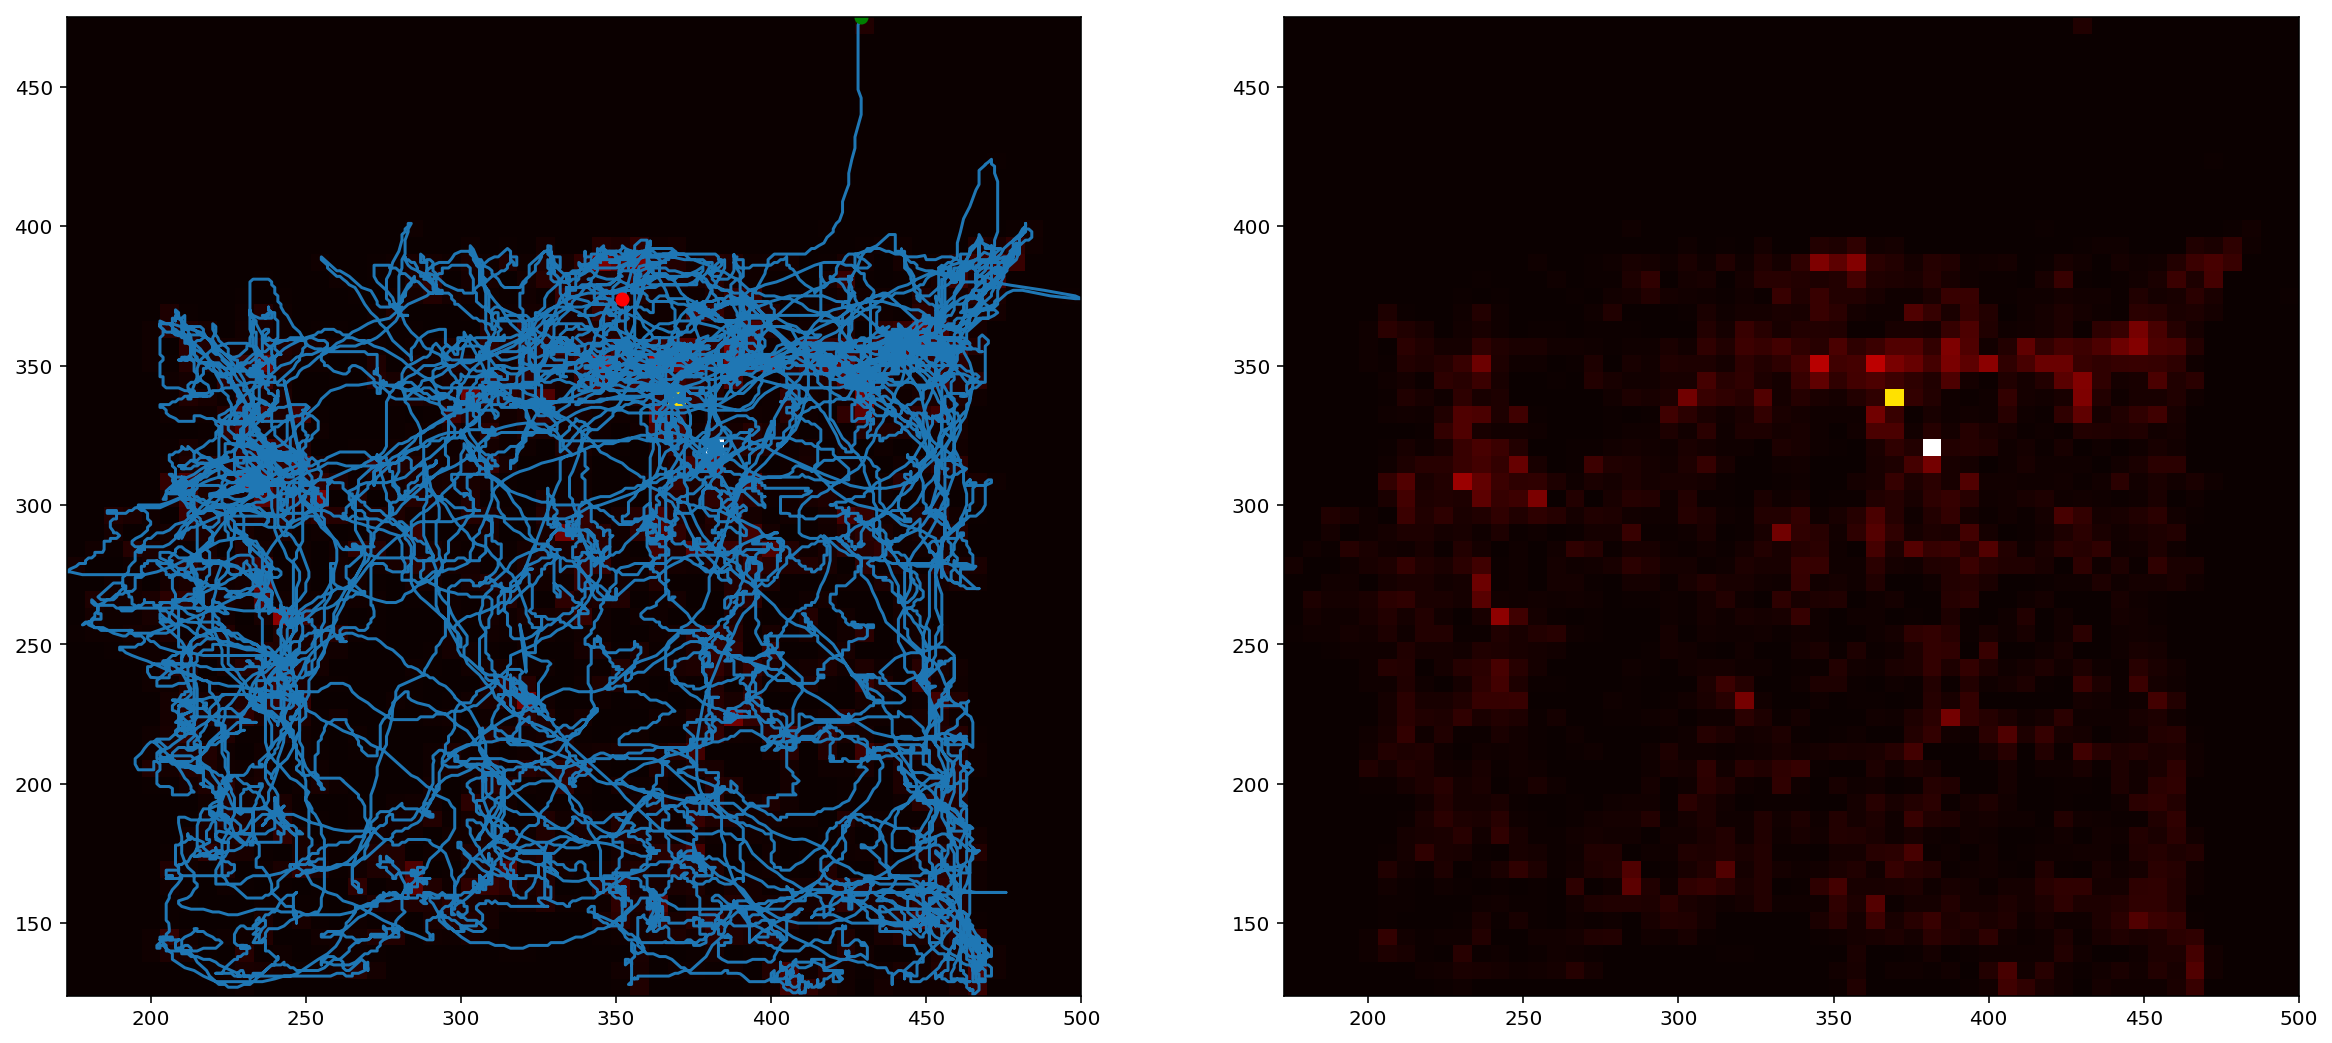

In [18]:
pc.plot_occupation_map()

In [19]:
(pc.maze_range[:,1]-pc.maze_range[:,0])/78

array([4.19230769, 4.5       ])

In [20]:
pc.maze_range

array([[173., 500.],
       [124., 475.]])

In [21]:
pc.maze_original

array([173., 124.])

## Load clu and spt to get spk_time

In [22]:
from numba import njit, prange

In [23]:
names = !ls ./Huey-20160213-04.clu.*

In [24]:
ids = np.sort(np.array([int(name.split('.')[-1]) for name in names]))
ids

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22,
       23, 25, 26])

In [25]:
spk_time = {}
for i in ids:
    clu = load_clu('./Huey-20160213-04.clu.'+str(i))
    spt = load_spk_time('./Huey-20160213-04.res.'+str(i))
    spt = spt/20e3
    spk_time[i] = get_spk_time_dict(spt, clu)

In [26]:
full_spk_time = {}
k = 0
for key, value in spk_time.items():
    for _key, _value in value.items():
        full_spk_time[k] = _value
        k += 1

In [27]:
def info_bits(Fr, px):
    Fr[Fr==0] = 1e-25
    overall = sum(px*Fr)
    return sum(px*(Fr/overall)*log2(Fr/overall))

In [28]:
def info_sparcity(Fr, px):
    Fr[Fr==0] = 1e-25
    idx = np.where(px!=0)[0]
    overall = sum(px*Fr)
    return sum(px*Fr**2/overall**2)

In [29]:
pc.get_fields(full_spk_time, kernlen=12, std=2)

In [30]:
@widgets.interact(i=(0, pc.n_fields-1, 1))
def show_pc(i=0):
    j = np.argsort(pc.metric['spatial_bit_smoothed_spike'])[::-1][i]
#     j = i
    pc.get_field(full_spk_time, j, kernlen=8, std=2)
    pc.plot_field(cmap='gray', marker=True, alpha=0.2, markersize=5)
    print 'bits/spike:', info_bits(pc.FR.copy().ravel(), pc.O.ravel()/float(pc.O.sum()))
    print 'bits/spike_smoothed:', info_bits(pc.FR_smoothed.copy().ravel(), pc.O.ravel()/float(pc.O.sum()))
    print 'sparcity', info_sparcity(pc.FR.copy().ravel(), pc.O.ravel()/float(pc.O.sum()))
    print pc.metric['spatial_bit_smoothed_spike'][j]
    print 'max(hz)', pc.FR_smoothed.max()
    print '90(hz)', np.percentile(pc.FR_smoothed, 95)
    print 'mean(hz)', sum(pc.P*pc.FR_smoothed)

interactive(children=(IntSlider(value=0, description=u'i', max=152), Output()), _dom_classes=('widget-interact',))

In [31]:
pc.rank_fields('spatial_bit_smoothed_spike')

In [32]:
pc.sorted_fields_id

array([ 67, 121,  21,   8, 109,  14, 107,  47,  55, 123,  91,  74, 104,
       118, 140, 119,  34,  11, 116,  46,   1,  95, 120, 112,   6,  22,
        42,  83,  24, 106, 113,  41,  23, 100,  15, 111,  99, 138,  97,
         9, 152,  28,  87,  19,  89, 102, 110, 141,  98, 139, 101,  65,
       137,  39, 105, 114,  13,  96,  30, 127,  92, 122,  81,  32,  25,
       142, 115, 103,  45, 149, 147,  56, 144, 125, 146, 124, 148,  27,
       108,  51, 150,  38, 126,  36,  33,  88,   4,  61,  35,  63,  66,
        70, 145,  50,  82,  86,  57,  12,  79, 129, 130,  20,   7,  53,
        58,  60,  62,  54,  93,  80,  84,  76, 131, 132, 136,  10, 133,
        71,  49,  68, 135,  78,  26,  31,  73,   3,  48,  85,  90,  16,
       117,  44,   0,  52,  69,   5,  43,  75, 143, 128,  40,  29, 151,
        37,  17,  72,  77, 134,   2,  94,  18,  59,  64])

In [33]:
pc.rank_fields('spatial_bit_smoothed_spike')

In [33]:
pc.sorted_fields_id = np.argsort(pc.metric['spatial_bit_spike']*pc.metric['spatial_bit_smoothed_spike'])

In [34]:
pc.sorted_fields_id

array([ 67, 121,  21,   8, 109,  14, 107,  47,  55, 123,  91,  74, 104,
       118, 140, 119,  34,  11, 116,  46,   1,  95, 120, 112,   6,  22,
        42,  83,  24, 106, 113,  41,  23, 100,  15, 111,  99, 138,  97,
         9, 152,  28,  87,  19,  89, 102, 110, 141,  98, 139, 101,  65,
       137,  39, 105, 114,  13,  96,  30, 127,  92, 122,  81,  32,  25,
       142, 115, 103,  45, 149, 147,  56, 144, 125, 146, 124, 148,  27,
       108,  51, 150,  38, 126,  36,  33,  88,   4,  61,  35,  63,  66,
        70, 145,  50,  82,  86,  57,  12,  79, 129, 130,  20,   7,  53,
        58,  60,  62,  54,  93,  80,  84,  76, 131, 132, 136,  10, 133,
        71,  49,  68, 135,  78,  26,  31,  73,   3,  48,  85,  90,  16,
       117,  44,   0,  52,  69,   5,  43,  75, 143, 128,  40,  29, 151,
        37,  17,  72,  77, 134,   2,  94,  18,  59,  64])

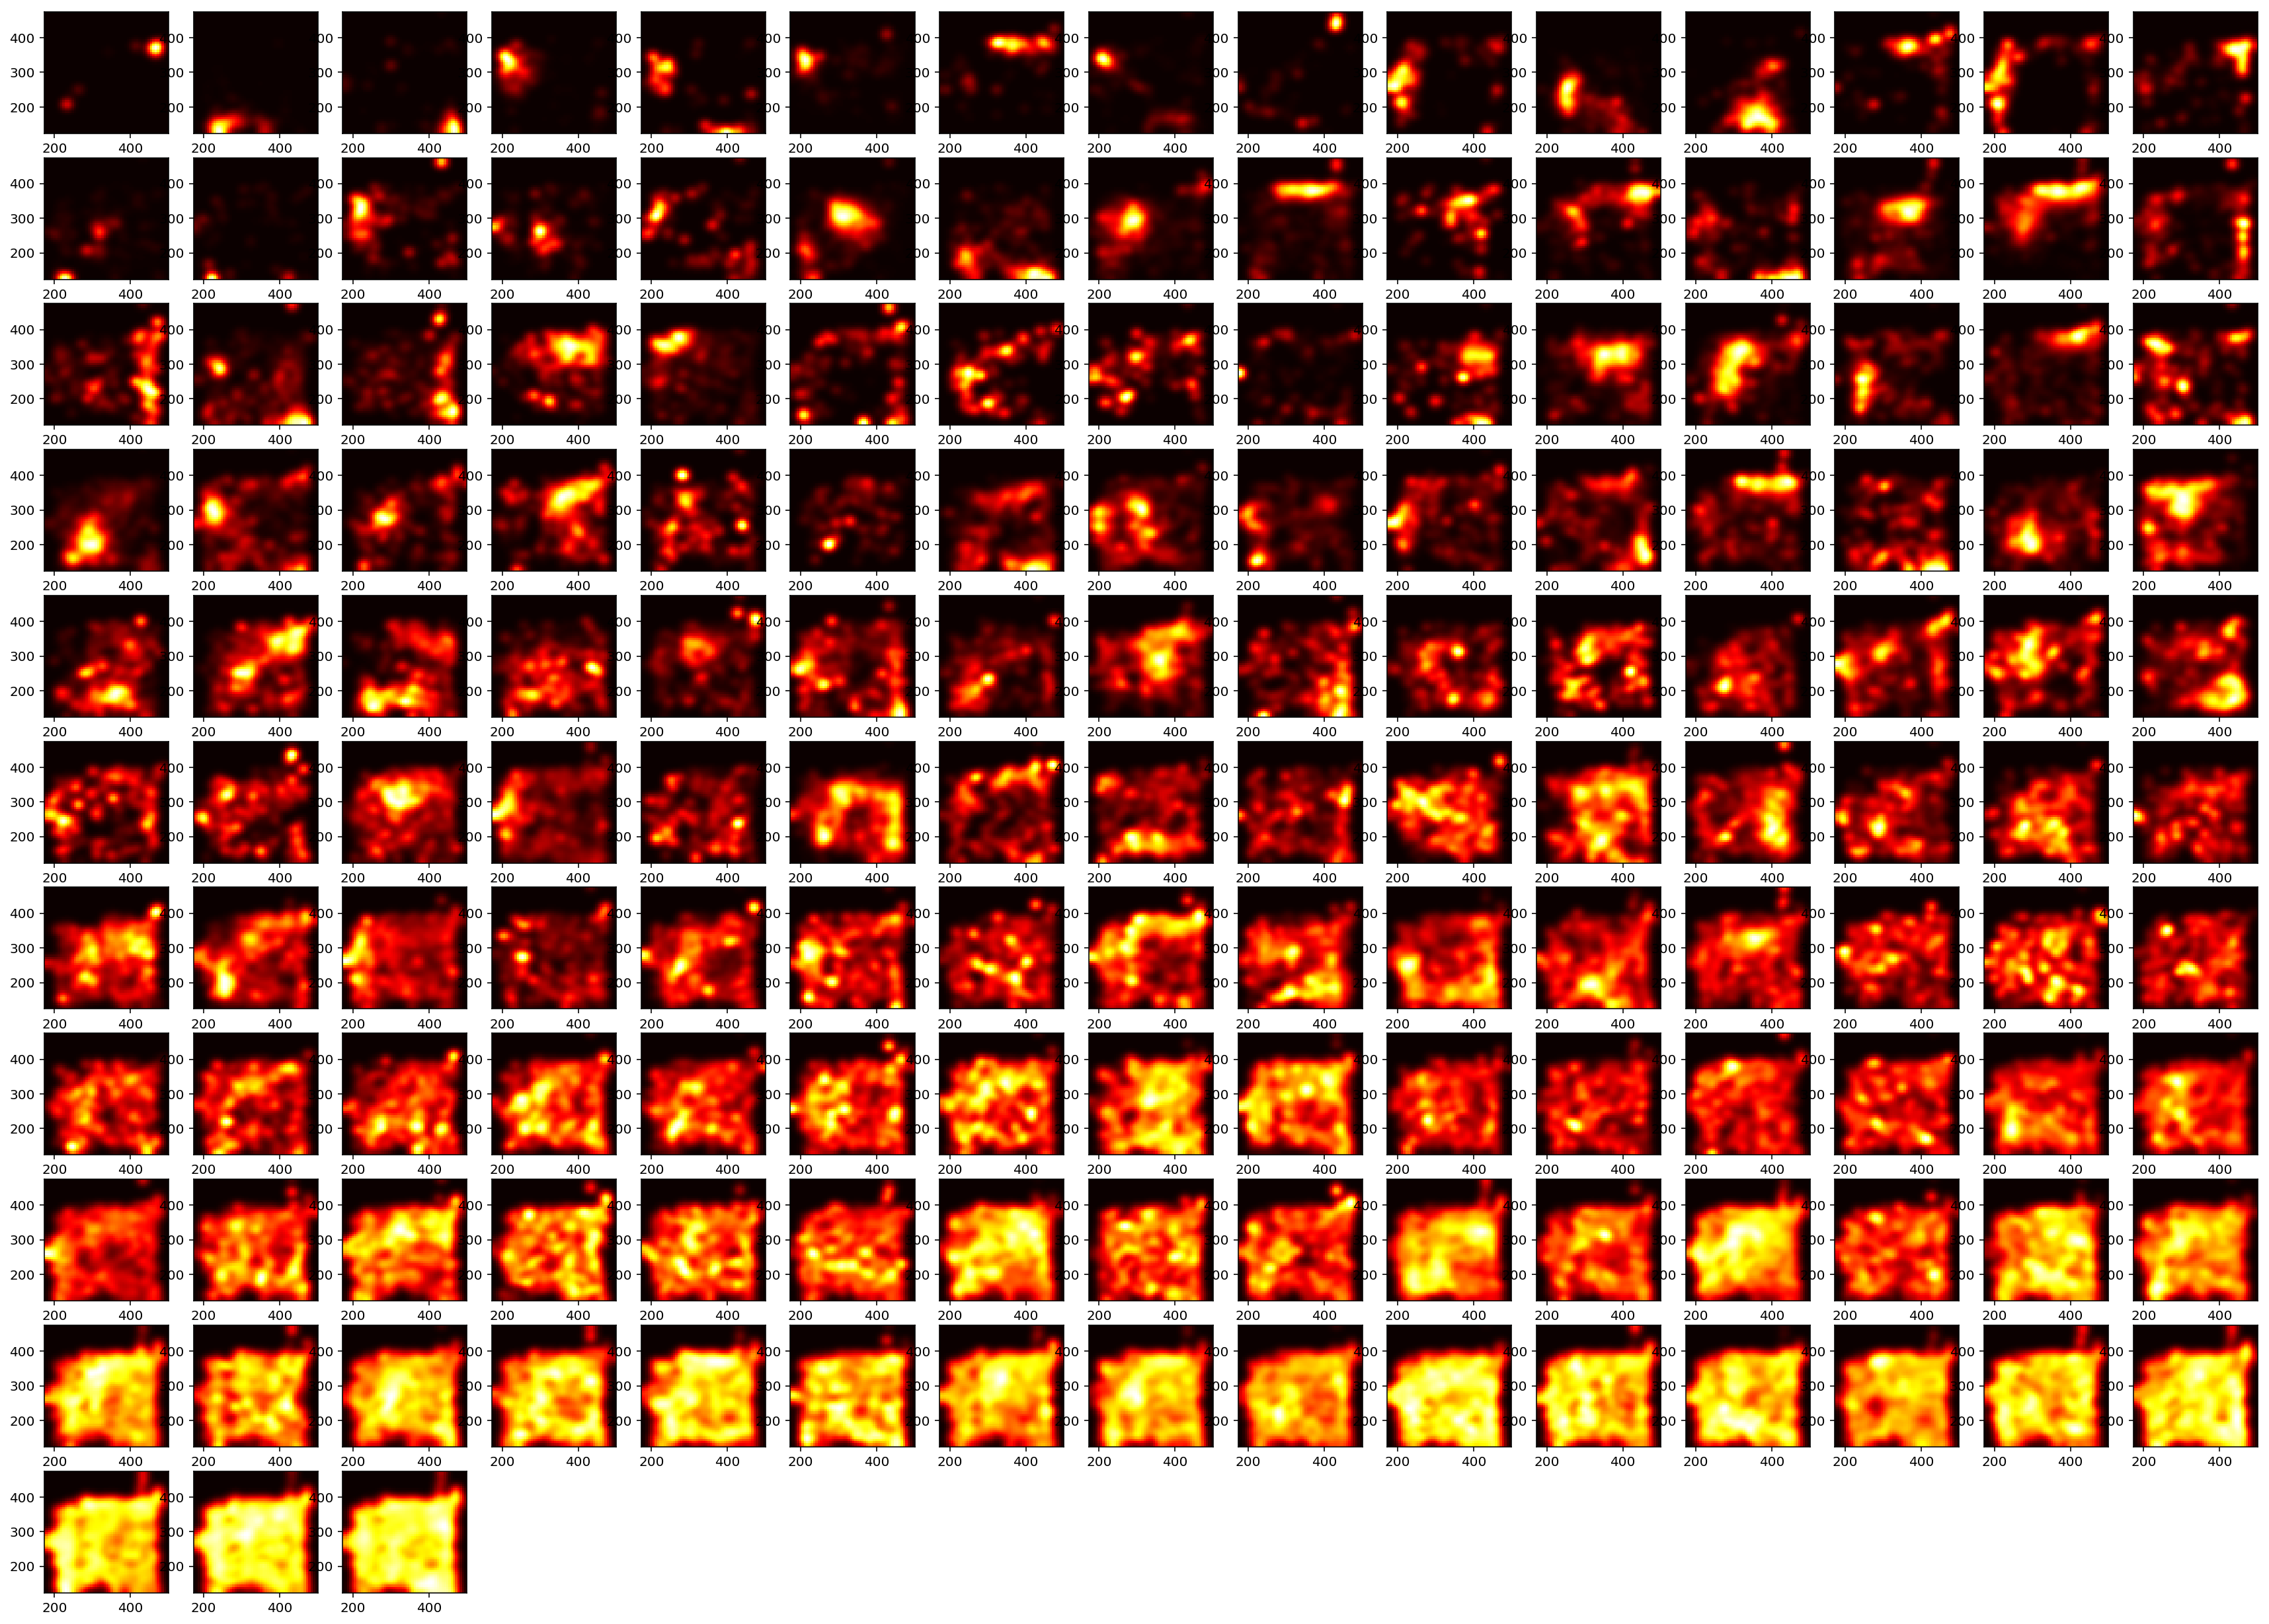

In [35]:
pc.plot_fields(N=15, size=2, cmap='hot', marker=False, order=True);

## Get single-unit-vector (suv) 

In [36]:
from spiketag.analysis import *

In [37]:
delta_t = 250e-3

In [265]:
n_cells = 38

In [266]:
suv = spk_time_to_suv(full_spk_time, pc.ts, delta_t=delta_t, sublist=pc.sorted_fields_id[:n_cells])

In [267]:
Fr = pc.fields_matrix[pc.sorted_fields_id[:n_cells]]

In [268]:
suv.shape

(38, 46686)

In [269]:
Fr.shape

(38, 58, 54)

# Decoding

In [270]:
# This is the key, otherwise log will go to -inf
Fr[Fr==0] = 1e-25

In [271]:
true_xy, post_2d = bayesian_decoding(Fr=Fr, suv=suv, pos=pc.pos, pos_offset=pc.maze_original, 
                                     bin_size=pc.bin_size, delta_t=delta_t)

In [272]:
post_xy = argmax_2d_tensor(X=post_2d)

In [273]:
post_2d = np.delete(post_2d, np.where(pc.v_smoothed<50)[0], axis=0)
true_xy = np.delete(true_xy, np.where(pc.v_smoothed<50)[0], axis=0)
post_xy = np.delete(post_xy, np.where(pc.v_smoothed<50)[0], axis=0)

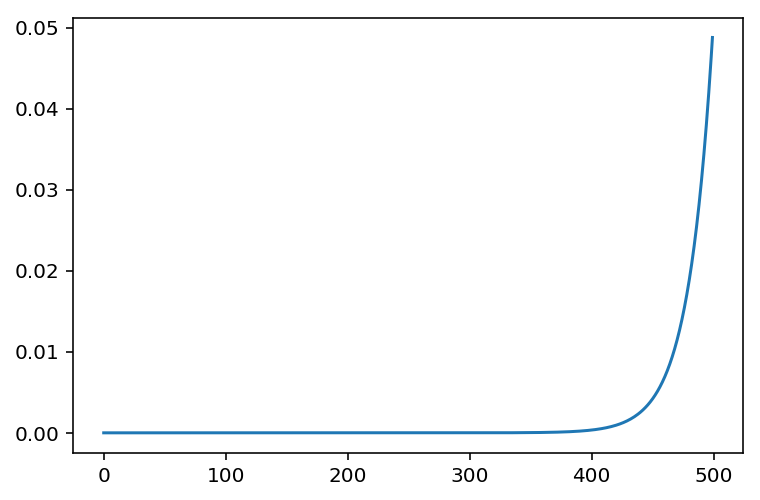

In [274]:
box = np.exp(0.05*np.arange(500))
box = box/float(box.sum())
plot(box)

In [275]:
def smooth(y, window_len):
    box = np.exp(0.0005*np.arange(window_len))
    box = box/float(box.sum())
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [276]:
smoothed_post_xy = np.zeros_like(post_xy)
smoothed_post_xy[:,0] = smooth(post_xy[:,0], window_len=80)
smoothed_post_xy[:,1] = smooth(post_xy[:,1], window_len=80)

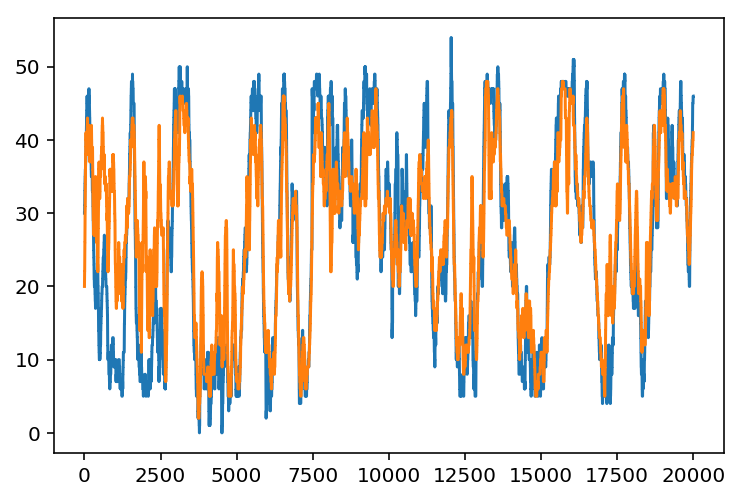

In [277]:
plot(true_xy[:20000,0])
plot(smoothed_post_xy[:20000,0])

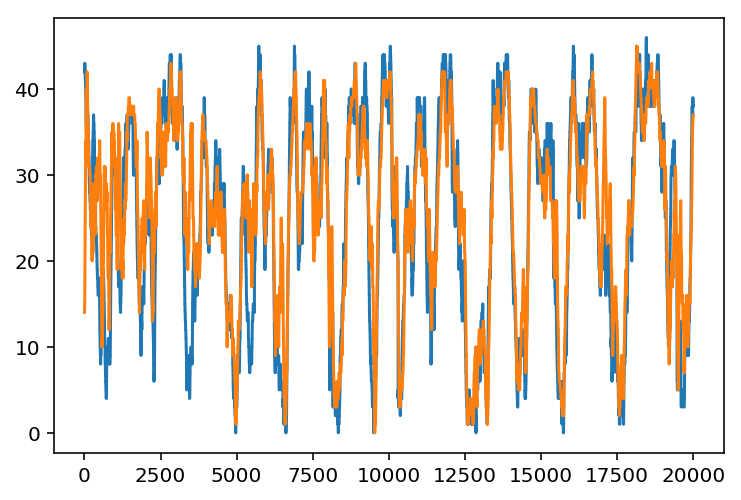

In [278]:
plot(true_xy[:20000,1])
plot(smoothed_post_xy[:20000,1])

In [279]:
df = np.linalg.norm(true_xy - smoothed_post_xy, axis=1)
df *= pc.bin_size

In [280]:
xy_length = pc.maze_range[:,1] - pc.maze_range[:,0]

In [281]:
print np.median(df[5000:])/xy_length
print np.mean(df[5000:])/xy_length

[0.09174312 0.08547009]
[0.11026155 0.1027223 ]


In [255]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.07565331 0.07048044]
[0.09365649 0.08725263]


In [121]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.09052793 0.08433798]


In [258]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0733945  0.06837607]
[0.08589167 0.08001874]


In [273]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.08289788 0.07722965]


In [288]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.08030985 0.07481858]


In [303]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.07989365 0.07443083]


In [317]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.07989365 0.07443083]


In [332]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0661569  0.06163336]
[0.07926676 0.07384681]


In [348]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0733945  0.06837607]
[0.0812411  0.07568615]


In [361]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0733945  0.06837607]
[0.0812411  0.07568615]


In [377]:
print np.median(df)/xy_length
print np.mean(df)/xy_length

[0.0733945  0.06837607]
[0.08101478 0.07547531]


In [435]:
np.percentile(df, 90)/xy_length

array([0.15677071, 0.14605135])

In [256]:
np.percentile(df[10000:20000], 80)/xy_length

array([0.11604689, 0.10811206])

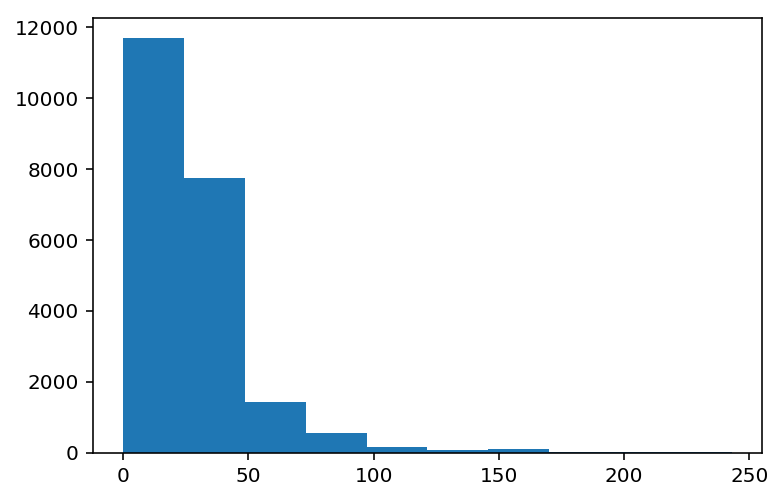

In [436]:
plt.hist(df);

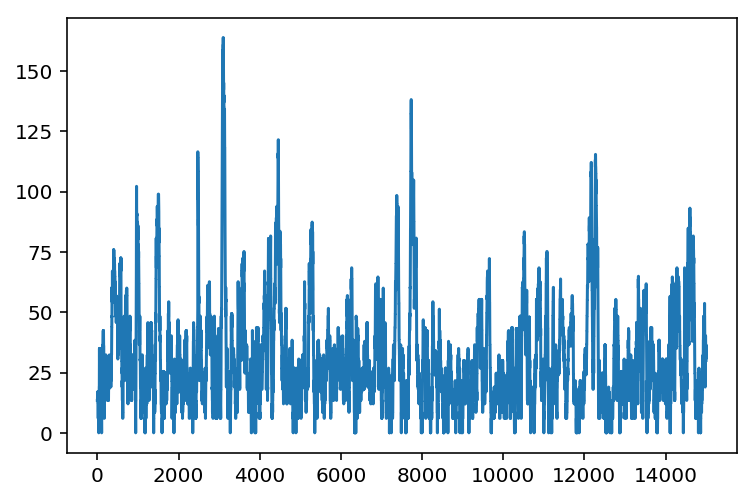

In [232]:
plot(df[5000:20000])

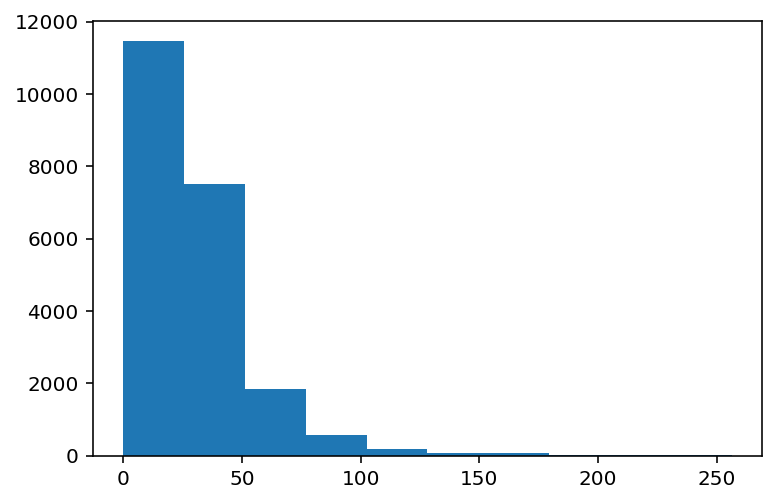

In [144]:
plt.hist(df);

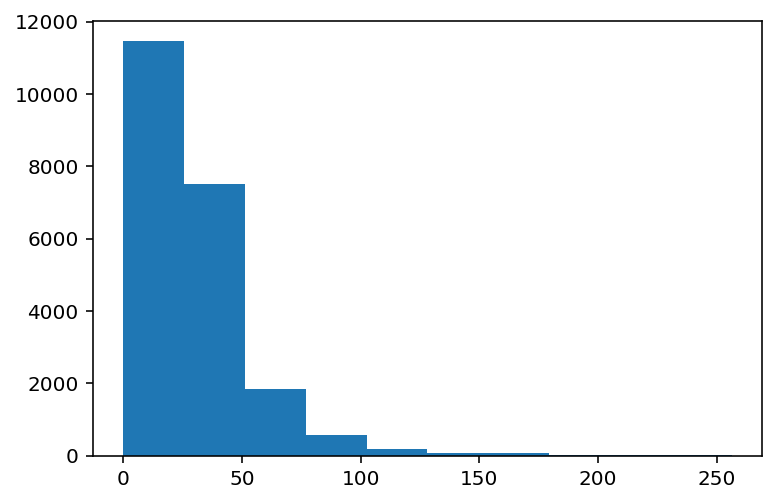

In [145]:
plt.hist(df);

In [258]:
@widgets.interact(i=(5000,true_xy.shape[0],2))
def show_post_2d(i=0):
    fig, ax = subplots(1,1,figsize=(5,5))
    ax.pcolormesh(post_2d[i])
    ax.plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
    ax.plot(smoothed_post_xy[i,0], smoothed_post_xy[i,1], 'go', markersize=20)

interactive(children=(IntSlider(value=5000, description=u'i', max=21777, min=5000, step=2), Output()), _dom_classes=('widget-interact',))

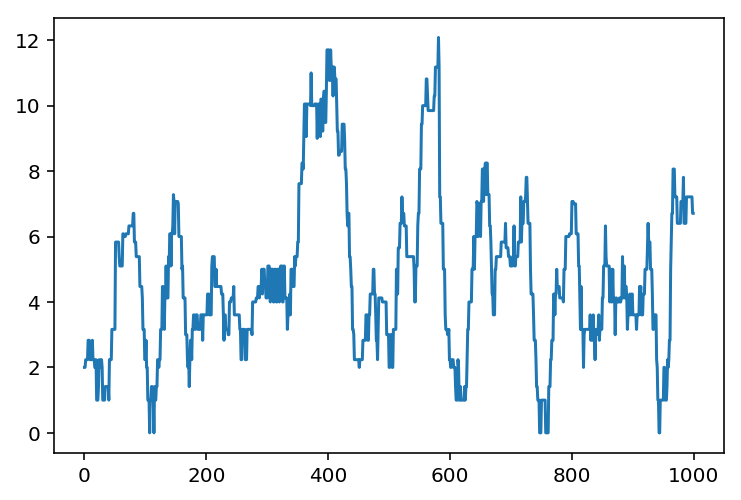

In [264]:
plot(df[5000:6000]/6)

### Fast version

In [41]:
@njit
def licomb_Matrix(w, X):
    '''
    input:
    1. `w` a weight vector (could be n single units vector(suv) )
    2. `X` which is a 3D matrix (could be n firing rate map)
    
    output:
    the linear combination w[0]*X[0] + w[1]*X[1] + ... + w[n]*X[N]
    X[0], X[1] ... X[N] are all 2D matrix
    '''
    Y = np.dot(w, X.reshape(w.shape[0], -1)).reshape(X.shape[1], X.shape[2])
    return Y

In [42]:
@njit(cache=True, parallel=True, fastmath=True)
def bayesian_decoding(Fr, suv, pos, pos_offset, bin_size, delta_t=100e-3):
#     log_posterior = lambda x,y,i: np.nansum(np.log(Fr[:,x,y]) * suv[:,i]) - 100e-3*Fr[:,x,y].sum(axis=0)
    true_xy = np.zeros((suv.shape[1],2))
    post_xy = np.zeros((suv.shape[1],2))
    post_2d = np.zeros((suv.shape[1], Fr.shape[1], Fr.shape[2]))
    possion_matrix = delta_t*Fr.sum(axis=0)
    log_fr = np.log(Fr) # make sure Fr[Fr==0] = 1e-12
    for i in prange(suv.shape[1]): # i is time point
        suv_weighted_log_fr = licomb_Matrix(suv[:,i], log_fr)
        true_xy[i] = (pos[i]-pos_offset)//bin_size
        post_2d[i] = exp(suv_weighted_log_fr - possion_matrix)
    return true_xy, post_2d

/anaconda2/lib/python2.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [62]:
true_xy, post_2d = bayesian_decoding(Fr=Fr, suv=suv[:, :], pos=pc.pos, pos_offset=pc.maze_original, 
                                     bin_size=pc.bin_size, delta_t=100e-3)

In [63]:
import torch
def argmax_2d_tensor(X):
    values, indices = torch.max(torch.from_numpy(X.reshape(X.shape[0],-1)), 1)
    post_xy = np.vstack((indices.numpy()%post_2d.shape[2], indices.numpy()//post_2d.shape[2])).T
    return post_xy

In [64]:
post_xy = argmax_2d_tensor(X=post_2d)
print post_2d.shape

(46686, 35, 32)


In [65]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [66]:
idx = np.where(pc.v_smoothed>25)[0]

In [67]:
smoothed_post_xy = np.zeros_like(post_xy)
smoothed_post_xy[:,0] = smooth(post_xy[:,0], 80)
smoothed_post_xy[:,1] = smooth(post_xy[:,1], 80)

In [49]:
smoothed_post_xy.shape

NameError: name 'smoothed_post_xy' is not defined

In [ ]:
plot(true_xy[:7000,0])
plot(smoothed_post_xy[:7000,0])

In [50]:
plot(true_xy[:7000,0])
plot(smoothed_post_xy[:7000,0])

NameError: name 'true_xy' is not defined

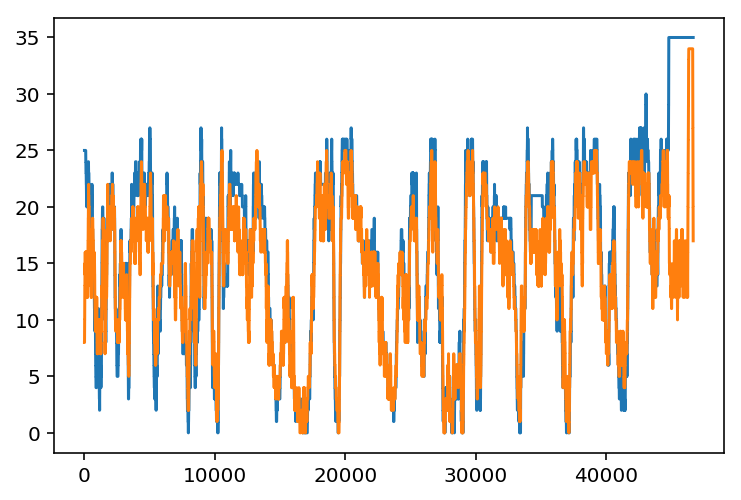

In [70]:
plot(true_xy[:,1])
plot(smoothed_post_xy[:,1])

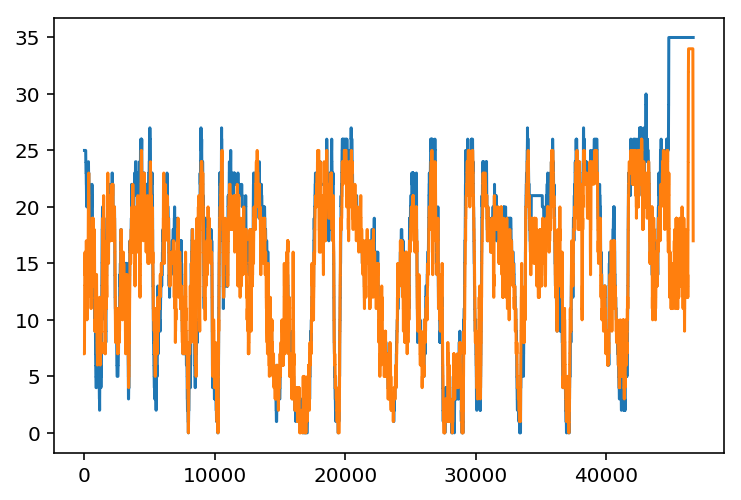

In [54]:
plot(true_xy[:,1])
plot(smoothed_post_xy[:,1])

In [71]:
df = np.linalg.norm(true_xy[pc.v_smoothed>50,:] - smoothed_post_xy[pc.v_smoothed>50,:], axis=1)

In [72]:
np.median(df), np.mean(df)

(3.1622776601683795, 3.7462008719962183)

In [73]:
np.median(df), np.mean(df)

(3.1622776601683795, 3.7462008719962183)

In [74]:
np.percentile(df, 90)

7.211102550927979

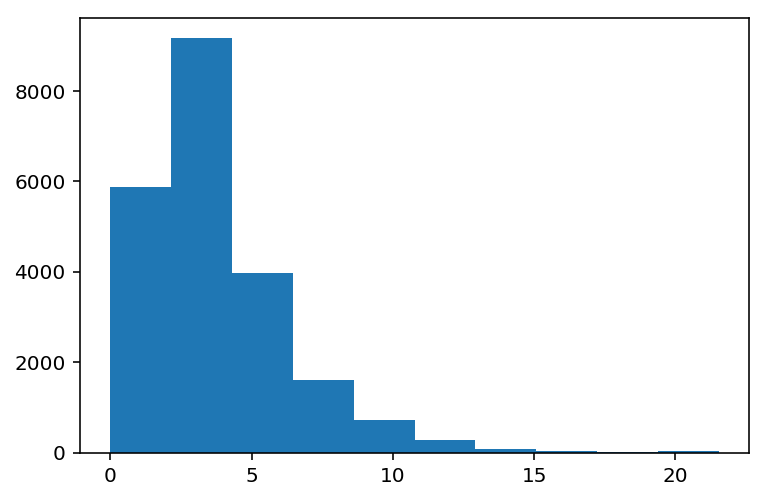

In [75]:
plt.hist(df);

In [57]:
@widgets.interact(i=(0,suv.shape[1],2))
def show_post_2d(i=0):
    if pc.v_smoothed[i] > 25 and suv[:,i].sum()>5:
        fig, ax = subplots(1,3,figsize=(18,5))
        ax[0].pcolormesh(post_2d[i,:,:])
        ax[0].plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
        ax[0].plot(smoothed_post_xy[i,0], smoothed_post_xy[i,1], 'go', markersize=20, alpha=0.5)
        print pc.v_smoothed[i]
        print suv[:,i]
        print suv[:,i]-suv[:,i-1]
        predominate_place_idx = np.argsort(suv[:,i])[::-1][:2]
        print predominate_place_idx
        print suv[predominate_place_idx,i]
        ax[1].pcolormesh(Fr[predominate_place_idx[0], :, :], label=suv[predominate_place_idx[0],i])
        ax[2].pcolormesh(Fr[predominate_place_idx[1], :, :], label=suv[predominate_place_idx[1],i])
        ax[1].legend()
        ax[2].legend()

interactive(children=(IntSlider(value=0, description=u'i', max=46686, step=2), Output()), _dom_classes=('widget-interact',))

## get the max index from matrix

In [69]:
X = np.random.randint(100, size=12).reshape(4,3)
X

array([[13, 16, 35],
       [67, 24, 79],
       [49, 33, 53],
       [ 6, 52, 52]])

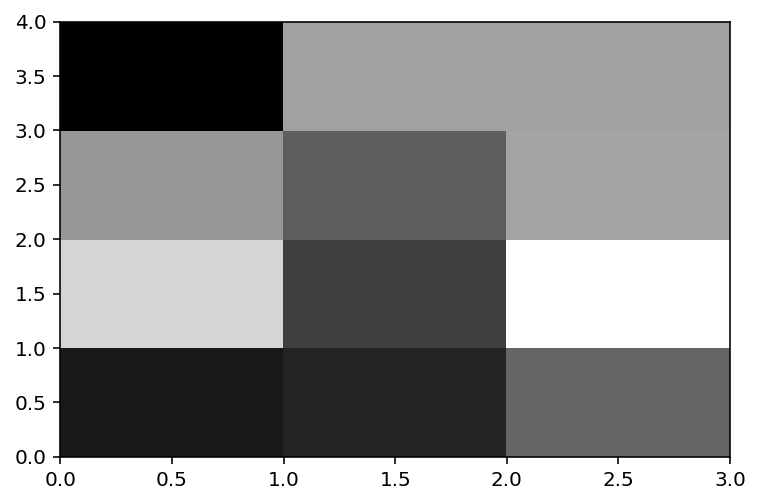

In [70]:
pcolormesh(X, cmap='gray')

In [71]:
argmax(X)%X.shape[1], argmax(X)//X.shape[1]

(2, 1)

### Slower but easier version

In [136]:
@njit(parallel=True, fastmath=True)
def bayesian_decoding(Fr, suv, pos, pos_offset, bin_size, delta_t=100e-3):
#     log_posterior = lambda x,y,i: np.nansum(np.log(Fr[:,x,y]) * suv[:,i]) - 100e-3*Fr[:,x,y].sum(axis=0)
    true_xy = np.zeros((suv.shape[1],2))
    post_xy = np.zeros((suv.shape[1],2))
    post_2d = np.zeros((suv.shape[1], Fr.shape[1], Fr.shape[2]))
    possion_matrix = delta_t*Fr.sum(axis=0)
    for i in prange(suv.shape[1]):
        true_xy[i] = (pos[i]-pos_offset)//bin_size
        for x in range(post_2d.shape[1]):
            for y in range(post_2d.shape[2]):
                post_2d[i,x,y] = exp( np.sum(np.log(Fr[:,x,y]) * suv[:,i]) - possion_matrix[x,y] )
    return true_xy, post_2d

In [137]:
true_xy, ref_post_2d = bayesian_decoding(Fr=Fr, suv=suv, pos=pc.pos, 
                                     pos_offset=np.array([173., 124.]), bin_size=10, delta_t=100e-3)

In [710]:
%%timeit
true_xy, post_2d = bayesian_decoding(Fr=Fr, suv=suv[:,100:150], pos=pc.pos, 
                                     pos_offset=np.array([173., 124.]), bin_size=10, delta_t=100e-3)

100 loops, best of 3: 12.3 ms per loop


In [136]:
def argmax_2d_tensor(X):
    post_xy = np.zeros((suv.shape[1],2))
    for i,x in enumerate(X):
        post_xy[i] = np.argwhere(x.max() == x)[0][::-1]
    return post_xy

In [137]:
post_xy = argmax_2d_tensor(X=post_2d)
print post_2d.shape

(32421, 35, 32)


In [138]:
true_xy.shape, post_xy.shape

((32421, 2), (32421, 2))

In [193]:
@widgets.interact(i=(0,suv.shape[1],2))
def show_post_2d(i=0):
    if pc.v_smoothed[i] > 25 and suv[:,i].sum()>5:
        fig, ax = subplots(1,3,figsize=(18,5))
        ax[0].pcolormesh(post_2d[i,:,:])
        ax[0].plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
        ax[0].plot(post_xy[i,0], post_xy[i,1], 'go', markersize=20, alpha=0.5)
        print pc.v_smoothed[i]
        print suv[:,i]
        print suv[:,i]-suv[:,i-1]
        predominate_place_idx = np.argsort(suv[:,i])[::-1][:2]
        print predominate_place_idx
        print suv[predominate_place_idx,i]
        ax[1].pcolormesh(Fr[predominate_place_idx[0], :, :], label=suv[predominate_place_idx[0],i])
        ax[2].pcolormesh(Fr[predominate_place_idx[1], :, :], label=suv[predominate_place_idx[1],i])
        ax[1].legend()
        ax[2].legend()

interactive(children=(IntSlider(value=0, description=u'i', max=32421, step=2), Output()), _dom_classes=('widget-interact',))

In [277]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [278]:
idx = np.where(pc.v_smoothed>25)[0]

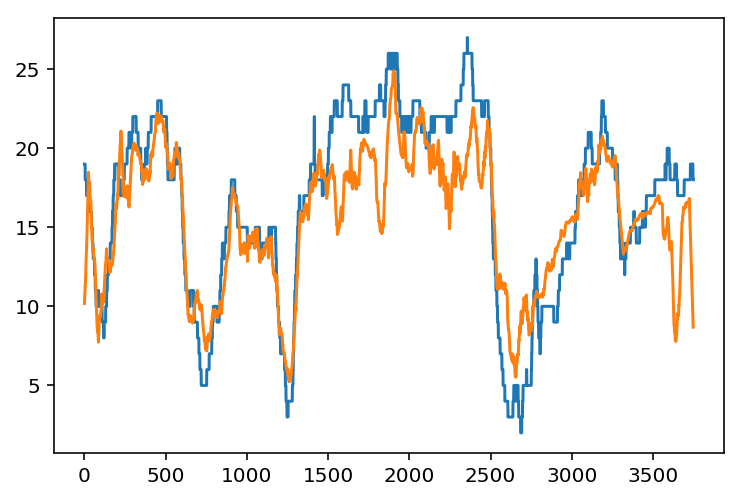

In [279]:
plot(true_xy[idx[1000:3948+800],1])
plot(smooth(post_xy[idx[1000:3948+800],1], 50))

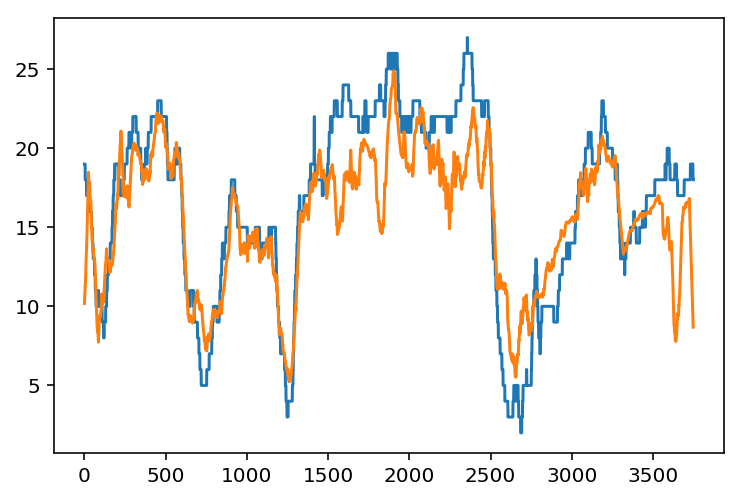

In [271]:
plot(true_xy[idx[1000:3948+800],1])
plot(smooth(post_xy[idx[1000:3948+800],1], 50))

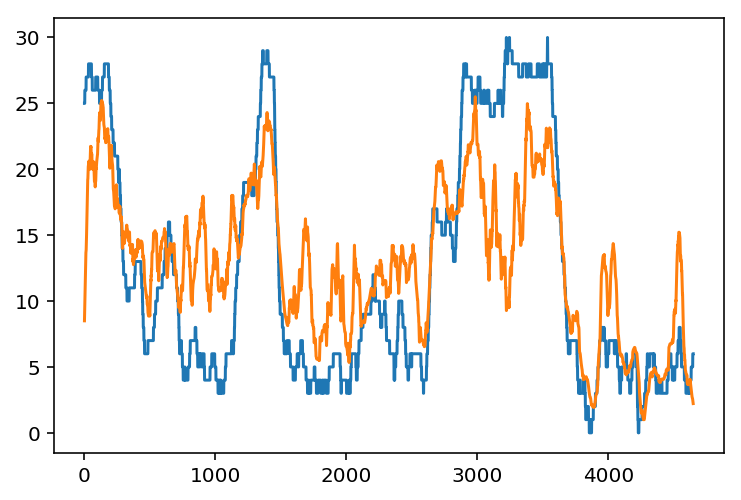

In [280]:
plot(true_xy[idx[100:3948+800],0])
plot(smooth(post_xy[idx[100:3948+800],0], 50))

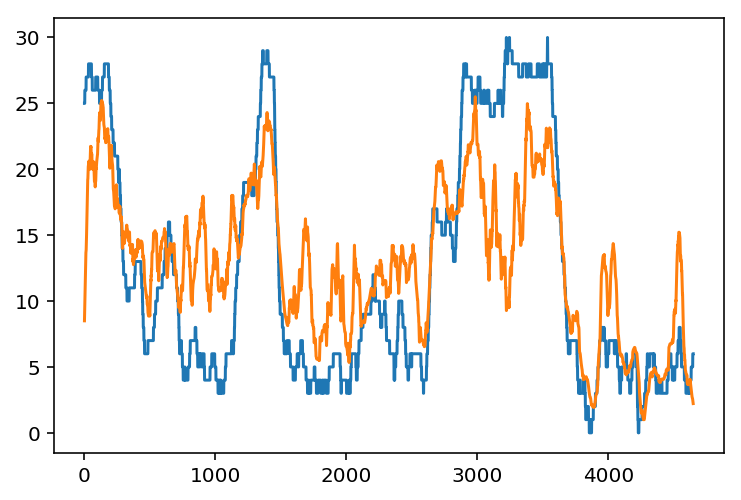

In [272]:
plot(true_xy[idx[100:3948+800],0])
plot(smooth(post_xy[idx[100:3948+800],0], 50))

In [357]:
df = np.linalg.norm(true_xy[pc.v_smoothed>25,:] - post_xy[pc.v_smoothed>25,:], axis=1)

In [360]:
np.median(df), np.mean(df)

(3.1622776601683795, 5.413660954504635)

In [338]:
np.percentile(df, 70)

5.385164807134504

In [339]:
from sklearn.metrics import mean_squared_error

In [348]:
mean_squared_error(true_xy[pc.v_smoothed>25,1], post_xy[pc.v_smoothed>25,1])

25.376529821843533

In [363]:
np.sqrt(mean_squared_error(true_xy[pc.v_smoothed>25,:] , post_xy[pc.v_smoothed>25,:]))

5.61060534448164

In [168]:
@widgets.interact(i=(0,suv.shape[1],2))
def show_post_2d(i=0):
    if pc.v_smoothed[i] > 25 and suv[:,i].sum()>5:
        fig, ax = subplots(1,3,figsize=(18,5))
        ax[0].pcolormesh(post_2d[i,:,:])
        ax[0].plot(true_xy[i,0], true_xy[i,1], 'ro', markersize=20, alpha=0.5)
        ax[0].plot(smooth(ref_post_xy[:,0], 50)[i], smooth(ref_post_xy[:,1], 50)[i], 'go', markersize=20, alpha=0.5)
        print pc.v_smoothed[i]
        print suv[:,i]
        print suv[:,i]-suv[:,i-1]
        predominate_place_idx = np.argsort(suv[:,i])[::-1][:2]
        print predominate_place_idx
        print suv[predominate_place_idx,i]
        ax[1].pcolormesh(Fr[predominate_place_idx[0], :, :], label=suv[predominate_place_idx[0],i])
        ax[2].pcolormesh(Fr[predominate_place_idx[1], :, :], label=suv[predominate_place_idx[1],i])
        ax[1].legend()
        ax[2].legend()

interactive(children=(IntSlider(value=0, description=u'i', max=32421, step=2), Output()), _dom_classes=('widget-interact',))